# Image alignment

The purpose of this notebook is to resize and align the ppl, xpl, and false-color TIMA images for use in data collection.


In [7]:
# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import pickle
import imutils
import sys

# Test out manual pixel coordinates

Text(0.5, 1.0, 'XPL Image')

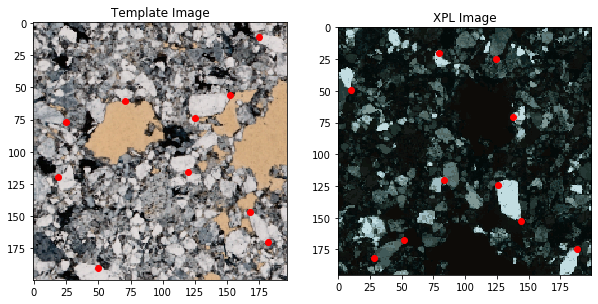

In [49]:
# create two lists of matched coordinate pairs

#xpl
pts1 = np.array([[126, 124], [144, 153], [188, 175], [83, 120], [10,49],
                 [138, 71],[52, 168], [28, 182], [124, 25], [79,20]])

#ppl
pts2 = np.array([[125, 74], [152, 56], [175, 11], [120, 116], [50, 190],
                 [71, 61],[168, 147], [182, 170], [25, 77], [19, 120]])
# load and view sample image
img = cv2.imread('Images/xplimg.png')
template = cv2.imread('Images/template.jpg')


plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(template)
# plot dots
plt.scatter(pts2[:,0], pts2[:,1], color='r')
plt.title('Template Image')

plt.subplot(1,2,2)
plt.imshow(img)
# plot red dot
plt.scatter(pts1[:,0], pts1[:,1],color='r')
plt.title('XPL Image')


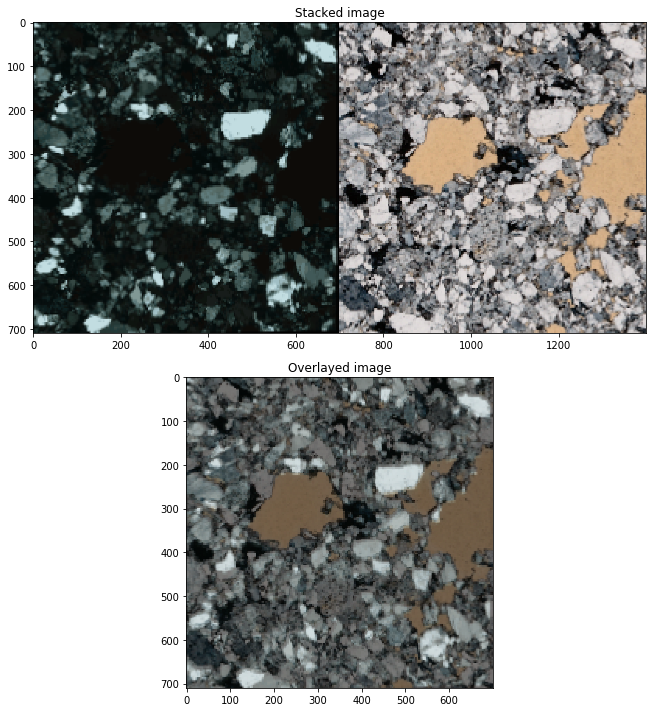

In [29]:
(H, mask) = cv2.findHomography(pts1, pts2, method = cv2.RANSAC)

# use the homography matrix to align the images
(h, w) = template.shape[:2]
aligned = cv2.warpPerspective(img, H, (w,h))

# resize both the aligned and template images so we can easily 
# visualize them on the screen
aligned = imutils.resize(aligned, width=700)
template = imutils.resize(template, width=700)

# side-by-side comparison of the output aligned image and the template
stacked = np.hstack([aligned, template])

# second image alignment visualization will be overlaying the
# aligned image on the template to get an idea of how good
# the image alignment is

overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# show the two output inmage alignment visualizations
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.title('Stacked image')
plt.imshow(stacked)
plt.subplot(2,1,2)
plt.title('Overlayed image')
plt.imshow(output)

plt.tight_layout()

# Edge detection

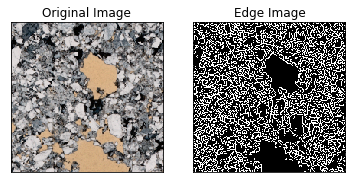

In [80]:
img = cv2.imread('Images/image.jpg')
edges = cv2.Canny(img, 100, 100)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

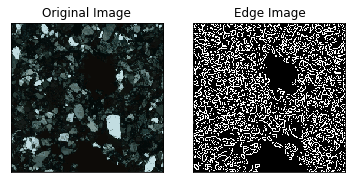

In [81]:
img = cv2.imread('Images/xplimg.png')
edges = cv2.Canny(img, 50, 2)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

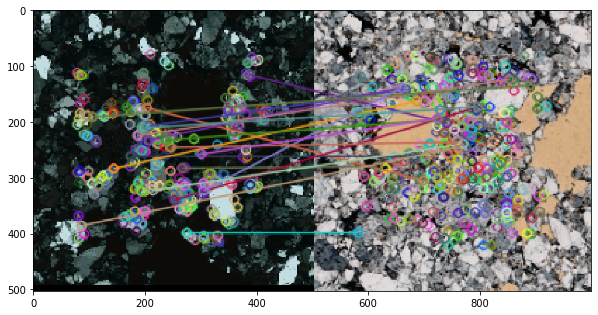

In [83]:
# open images
# transformed ppl image
#img = cv2.imread('Images/image.jpg')

# larger ppl image
#img = cv2.imread('Images/larger_img.jpg')

# transformed xpl image
img = cv2.imread('Images/xplimg.png')
imgGray = cv2.Canny(img, 50, 2)

# original ppl image
template = cv2.imread('Images/template.jpg')
templateGray = cv2.Canny(template, 100, 100)

'''Uncomment when you arent using edges'''
# img = cv2.imread('smileyface.jpeg')
# template = cv2.imread('template.jpeg')

# convert to grayscale
#imageGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
height, width = templateGray.shape

# use ORB to detect keypoints and extract (binary) 
# local invariant features
orb = cv2.ORB_create(500)
kp1, d1 = orb.detectAndCompute(img, None)
kp2, d2 = orb.detectAndCompute(templateGray, None)

# match features
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.DescriptorMatcher_create(method)
matches = matcher.match(d1, d2, None)

# sort matches by their distance (smaller distance,
# means more similar features)
matches = sorted(matches, key=lambda x: x.distance)
no_of_matches = len(matches)

# keep only the top matches
keep = int(len(matches) * 0.05)
matches = matches[:keep]

# check to see if we should visualize the matched keypoints
matchedVis = cv2.drawMatches(img, kp1, template, kp2, matches, None)
matchedVis = imutils.resize(matchedVis, width = 1000)

plt.figure(figsize=(10,8))
plt.imshow(matchedVis)

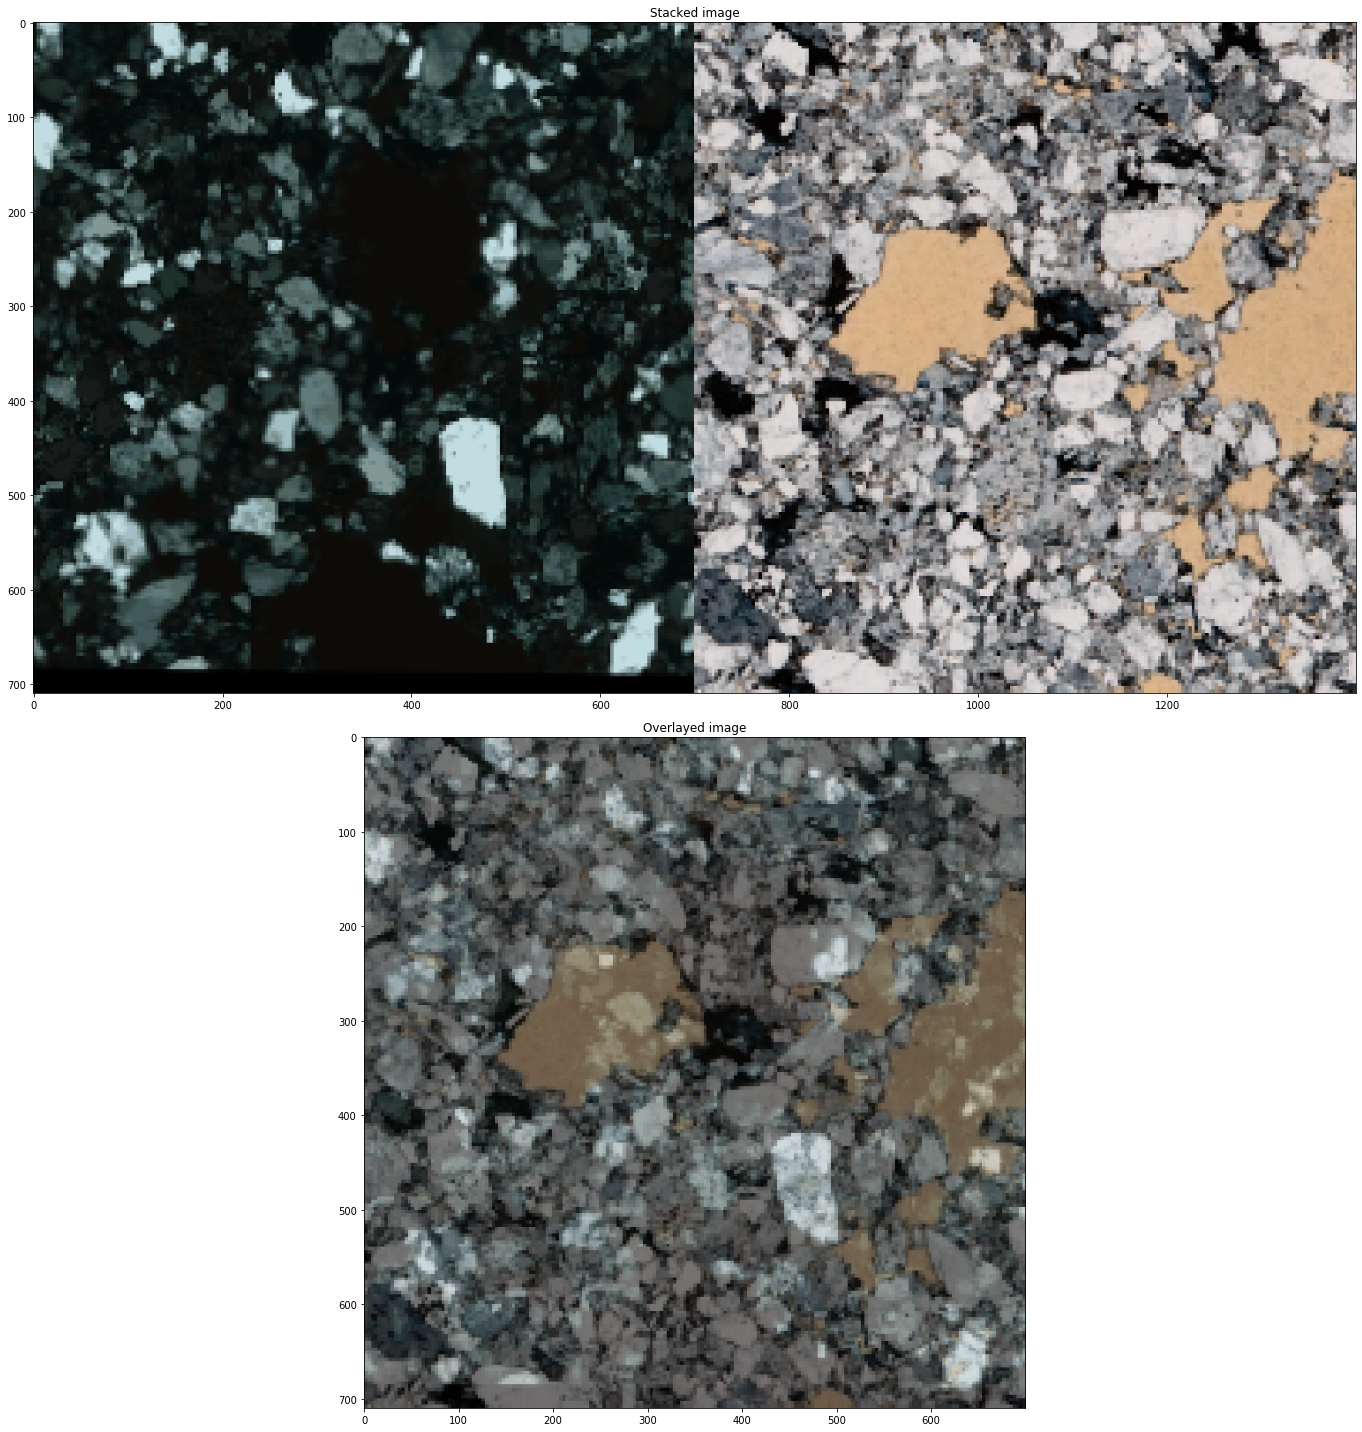

In [84]:
# compute homography matrix between two sets of matched points
(H, mask) = cv2.findHomography(pts1, pts2, method = cv2.RANSAC)

# use the homography matrix to align the images
(h, w) = template.shape[:2]
aligned = cv2.warpPerspective(img, H, (w,h))


# resize both the aligned and template images so we can easily 
# visualize them on the screen
aligned = imutils.resize(aligned, width=700)
template = imutils.resize(template, width=700)

# side-by-side comparison of the output aligned image and the template
stacked = np.hstack([aligned, template])

# second image alignment visualization will be overlaying the
# aligned image on the template to get an idea of how good
# the image alignment is

overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# show the two output inmage alignment visualizations
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
plt.title('Stacked image')
plt.imshow(stacked)

plt.subplot(2,1,2)
plt.title('Overlayed image')
plt.imshow(output)

plt.tight_layout()

# Use manually selected keypoints

Given our organized pairs of keypoint matches, now we are ready to align the image

In [74]:
df = pd.read_pickle('homography_pts.pkl')
df.head()

ppl          xpl       labels
0   [564, 684]   [564, 684]   [564, 689]
1   [759, 898]   [754, 896]   [756, 900]
2  [800, 1245]  [804, 1252]  [807, 1252]
3  [148, 1526]  [143, 1529]  [146, 1533]
4   [115, 196]   [115, 198]   [117, 200]

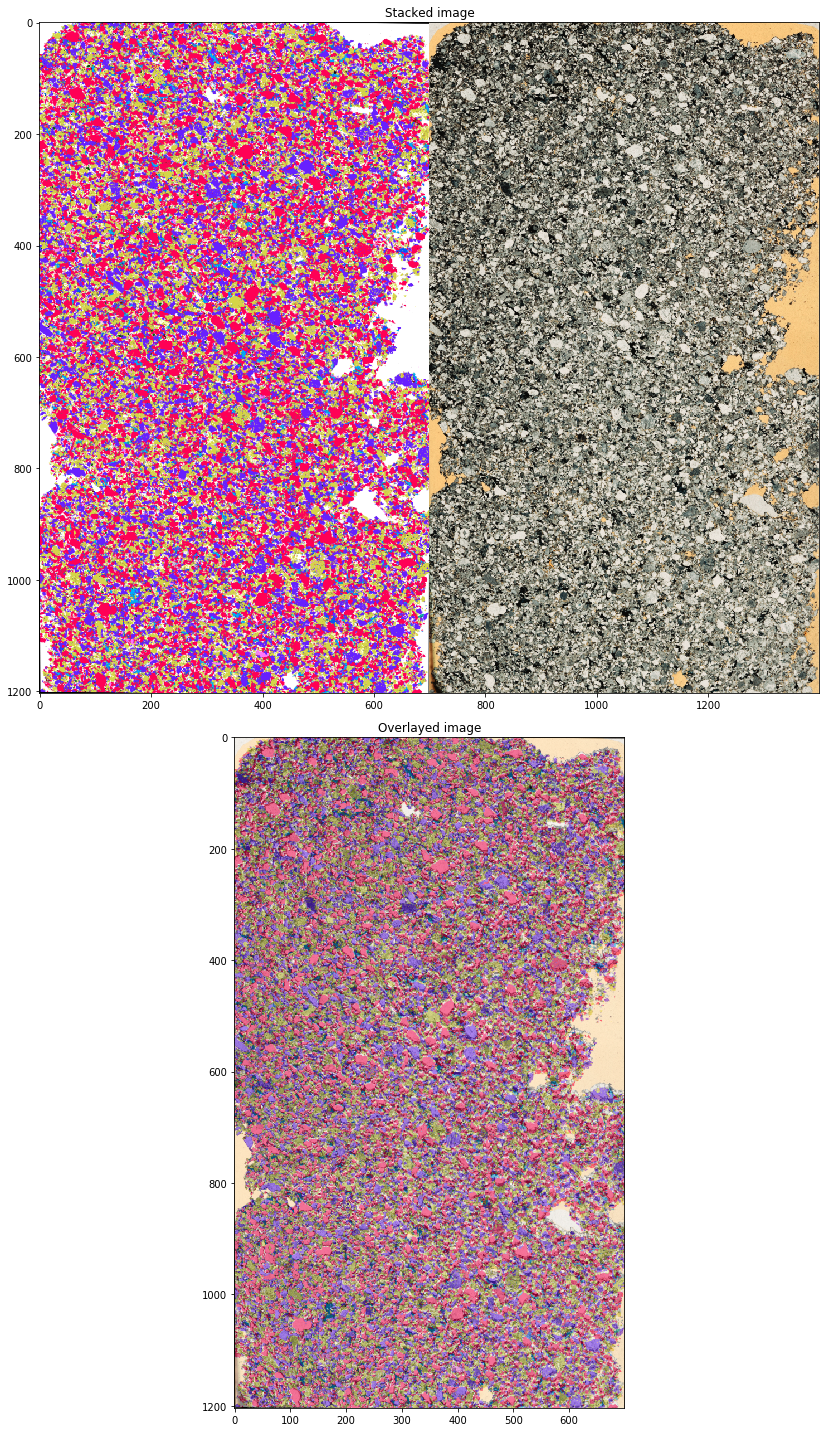

In [79]:
# get pts from df
pts1 = np.array(df['ppl'].tolist())
pts2 = np.array(df['labels'].tolist())

template = cv2.imread('Images/ppltest.jpg')
img = cv2.imread('Images/labels.png')

# compute homography matrix between two sets of matched points
(H, mask) = cv2.findHomography(pts1, pts2, method = cv2.RANSAC)

# use the homography matrix to align the images
(h, w) = template.shape[:2]
aligned = cv2.warpPerspective(img, H, (w,h))


# resize both the aligned and template images so we can easily 
# visualize them on the screen
aligned = imutils.resize(aligned, width=700)
template = imutils.resize(template, width=700)

# side-by-side comparison of the output aligned image and the template
stacked = np.hstack([aligned, template])

# second image alignment visualization will be overlaying the
# aligned image on the template to get an idea of how good
# the image alignment is

overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 0.5, output, 0.5, 0, output)

# show the two output inmage alignment visualizations
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
plt.title('Stacked image')
plt.imshow(stacked)

plt.subplot(2,1,2)
plt.title('Overlayed image')
plt.imshow(output)

plt.tight_layout()


# plt.figure(figsize=(8,10))
# # plot original (left) and template (right)
# plt.subplot(1,2,1)
# plt.title('Original (left); template (right)')
# plt.imshow(matchedVis)
# # plot the newly aligned image
# plt.subplot(1,2,2)
# plt.title('Aligned image')
# plt.imshow(aligned)

## References

https://www.geeksforgeeks.org/image-registration-using-opencv-python/